Noah Croes

i6220934

# Data Analysis

# Clinic 3: Classification with missing values & inbalanced data

## DELIVERABLES (DEADLINE 22/March late night, wildcards possible)

Instructions for the deliverable: 

* Make sure that you include a proper amount/mix of comments, results and code.

* In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook.

* You are asked to deliver **only your executed notebook file, .ipnyb** and nothing else. Enjoy!

* The second part of the assignment is purposefully left open-ended.

* Honor code applies to these tasks. Only individual work should be submitted.

* Data science is a collaborative activity. While you may talk with others about the clinic, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** below.

**Names of collaborators**: 
***


# 0. Introduction

In this clinic, we will continue navigating the amazing world of modeling and explore classification models under extreme inbalance and missing values scenarios.

The first part of the assignment (Questions 1-9) will help you understand the impact of inbalance and missingness in the classification performance and explore different scenarios on how to improve. Most steps are laid out for you, but you are welcome to deviate.

The second part of the assignment (Question 10) is purposefully left open-ended (as in previous clinics). In this case, you will be allowed to compare different classifiers of your choice in an effort to deal with the imbalance in the data. 

After this clinic, you should feel comfortable with the following:

1. Run Classification Models (Logistic Regression, Decision Trees, Random Forests, etc.) in Python
1. Explain and tackle issues like missing values or class inbalance in your dataset
1. Judge the results of a classification model using AUROC scores
1. Select a proper algorithm that works well with your data using techniques (see also last week) like:
    * Cross Validation
    * Regularization


## Score breakdown

Question | Points
--- | ---
[Question 1](#q1) | 3
[Question 2](#q2) | 3
[Question 3](#q3) | 4
[Question 4](#q4) | 4
[Question 5](#q5) | 4
[Question 6](#q6) | 6
[Question 7](#q7) | 4
[Question 8](#q8) | 8
[Question 9](#q9) | 4
[Question 10](#q10)| 15 
Total | 55

This score will be scaled down to 1 and that will be your final clinic score.

In [49]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn as sns
sns.set(context='paper')

## Part 1: Determine the Inbalance (Asymmetry)

First, we would like to notice in our data that they are highly unbalanced (assymetric). Load the data which should contain 9 columns (`health`, `age`, `sex`, `educ`, `sexornt`, `partyid`, `race`, `married`, `income`). `Age`, `educ` (how many years of education a person has) and `income` are quantitative, the others are qualitative.

In [50]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


Our goal is to predict if a person is in poor health or not. Let's create some dummy variables in order to measure that.


In [51]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth

In [52]:
gssdata.describe()

,age,educ,married,income,poorhealth,notpoorhealth
count,1551.000000,1551.000000,1551.000000,963.000000,1551.000000,1551.000000
mean,48.172792,13.803353,0.732431,15633.177570,0.063830,0.936170
std,17.051151,3.011700,0.442835,5064.191118,0.244528,0.244528
min,18.000000,0.000000,0.000000,500.000000,0.000000,0.000000
25%,33.500000,12.000000,0.000000,13750.000000,0.000000,1.000000
50%,48.000000,14.000000,1.000000,18750.000000,0.000000,1.000000
75%,61.000000,16.000000,1.000000,18750.000000,0.000000,1.000000
max,89.000000,20.000000,1.000000,18750.000000,1.000000,1.000000


### Question 1 <a name="q1"></a>

a) Can you quantify what is the degree of inbalance? Mention a percentage of the split between the positive and the negative class.<br>
b) What is the majority and the minority class?<br>
c) What would be the accuracy of a classifier that predicts everybody NOT being in poor health?<br>
d) Discuss (with each other and the teachers) why accuracy is not a good metric.<br>

**Your answer goes here**

a). The split between positive and negative is large. Approximately 93.6% of the people are in good health, while only around 6.4% is in poor health, leading to a large degree of imbalance within the dataset.

b). The majority class is in good health, while the minority class is in poor health.

c). The accuracy of the classifier prediction everybody is not in poor health, i.e. predicting everyone is in good health, is 0.936. The formula of the accuracy $\frac{TP + TN}{n}$ simplifies in this case to simply $\frac{TP}{n}$, since it assumes all instances are of the majority class.

d). If we were to train our classifier on our dataset and solely use accuracy as an evaluation metric we would see that our model scores very high with even the simplest models, since it would indeed classify most new datapoints correctly as by far the majority of the datapoints fall within the same classification. However, we are interested in evaluating how good the model performs on classifying "special/minority" cases within our dataset, in this case the ones in poor health. Therefore, using accuracy as an evaluating metric in this case is not suitable. Additionally, accuracy does not take into account the cost of false negatives or the importance of correctly predicting minority class instances, which is often important within classification tasks.

In [53]:
####HERE YOU CAN ADD CODE AND MORE COMMENTS
'''
gssdata.hist(figsize=(7,7))
plt.tight_layout()'''
poor_health = gssdata['poorhealth'].value_counts()

print('Value counts:',poor_health)
print('Percentage not in poor health:', str(poor_health[0]/sum(poor_health)*100)+"%")
print('Percentage in poor health:', str(poor_health[1]/sum(poor_health)*100)+"%")



Value counts: poorhealth
0    1452
1      99
Name: count, dtype: int64
Percentage not in poor health: 93.61702127659575%
Percentage in poor health: 6.382978723404255%


## Part 2: Fit a logistic model ignoring missing values

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model. In part 3, you will be asked to regularize (with cross-validation) to make sure you do not overfit, but for this part, we will keep things simple.

First, we need to do a small amount of data clean-up (ignoring missingness for now in `income`). Best practice would be to split into train/test first before looking at the data, but again, we can keep it simple in this part.

If you ignore the missingness `sklearn` might crash (`ValueError: Input contains NaN, infinity or a value too large for dtype('float64')`.) So you can also consider not using that variable in the model

In [54]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [55]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.head()

(1551, 22)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,False,False,True,False,False,False,True,False,False,True
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,False,False,True,False,False,True,False,False,False,True
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,False,False,True,False,False,True,False,False,False,True


### Question 2 <a name="q2"></a>

In the code below try to fit your logistic regression model and provide some short comments on the performance of the model. You don't need to be detailed (yet), but make sure to make 1-2 observations at least.

In [56]:
######HERE YOUR CODE TO FIT THE MODEL
######
######
######Look up LogisticRegression() from scikitlearn
from sklearn.linear_model import LogisticRegression

X = gssdata.drop(['health','sex', 'sexornt','partyid','race', 'poorhealth','notpoorhealth','income'], axis = 1)
Y = gssdata['poorhealth']

model = LogisticRegression(fit_intercept=True, penalty=None, max_iter=1000)
model.fit(X, Y);


In [57]:
model.intercept_, model.coef_

(array([-1.60976792]),
 array([[ 0.03351275, -0.19763325, -0.20557799, -0.04633147,  1.48511874,
         -5.9579024 ,  1.00217521,  1.86084053, -0.52589879, -0.27962162,
         -0.80424751, -0.50145538, -0.54834644, -0.5599661 ]]))

In [58]:
model.classes_

array([0, 1])

In [59]:
Prob_hat_one = model.predict_proba(X)[:, 1]
Prob_hat_one.shape

(1551,)

Accuracy 0.9374597034171502


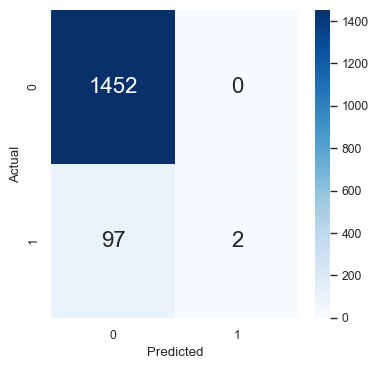

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y, model.predict(X))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

print(f'Accuracy {np.mean(model.predict(X) == Y)}')

**Your answer goes here**


If we were to use solely accuracy to benchark the performance we would score highly due to the 1452 TN cases. However, we have almost no TP cases (likely due to overfitting data), which are the cases we are interested in.

---

## 2a: Handling missingness approach \#1: remove observations. 

We do not know how sklearn will treat the missing values (the `NaN`s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

### Question 3 <a name="q3"></a>

In the code below, remove all observations that are not complete. Report on how many samples were dropped. Do a quick check to see how dropping observations affected the amount of poor health individuals. Do an appropriate plot to show this.

In [61]:
##In the code below: Remove all observations that are not complete
##Report on how many samples were dropped.
def remove_missing_data(data:pd.DataFrame):
    """ Method for removing all rows that have missing data.

    Args:
        data (pd.DataFrame): dataframe to inspect

    Returns:
        _type_: cleaned dataframe
    """
    original_datapoint_count = len(data)
    
    cleaned_data = data.dropna()

    dropped_count = original_datapoint_count - len(cleaned_data)

    print(f'We started with {original_datapoint_count} # of data points')
    print(f'We are left with {len(cleaned_data)} of data points and removed a total of {dropped_count} data points')

    return cleaned_data

In [62]:

#Do a quick check to see how dropping observations affected the amount of poor health individuals
#Do an appropriate plot to show this (e.g. boxplot)

gssdata_full = remove_missing_data(gssdata); #<---this should be your final data frame.
def combine_data_counts(data1: pd.DataFrame, data2:pd.DataFrame,column:str) -> pd.DataFrame:
    """ Combines two dataframes into one with a new column labeling from which dataframe the instances originate.
        Used for plotting.

    Args:
        data1 (pd.DataFrame): first dataframe
        data2 (pd.DataFrame): second dataframe
        column (str): column we want to inspect

    Returns:
        pd.DataFrame: combined dataframe of the data1 and data2
    """
    counts_original = pd.DataFrame(data1[column].value_counts());
    counts_new = pd.DataFrame(data2[column].value_counts());

    print('Percentage not in poor health original:', str((counts_original.iloc[0] / counts_original.sum() * 100).iloc[0])+"%")
    print('Percentage in poor health original:', str((counts_original.iloc[1] / counts_original.sum() * 100).iloc[0])+"%")
    print('Percentage not in poor health cleaned:', str((counts_new.iloc[0] / counts_new.sum() * 100).iloc[0])+"%")
    print('Percentage in poor health cleaned:', str((counts_new.iloc[1] / counts_new.sum() * 100).iloc[0])+"%")

    counts_original['Dataset'] = 'Original';
    counts_new['Dataset'] = 'Cleaned';

    combined_data = pd.concat([counts_original, counts_new])
    print(combined_data)
    return combined_data

combined_data = combine_data_counts(gssdata, gssdata_full, 'poorhealth')

We started with 1551 # of data points
We are left with 963 of data points and removed a total of 588 data points
Percentage not in poor health original: 93.61702127659575%
Percentage in poor health original: 6.382978723404255%
Percentage not in poor health cleaned: 98.33852544132918%
Percentage in poor health cleaned: 1.6614745586708204%
            count   Dataset
poorhealth                 
0            1452  Original
1              99  Original
0             947   Cleaned
1              16   Cleaned


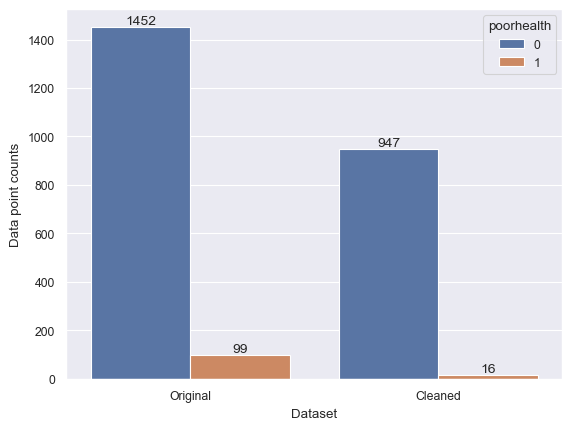

In [63]:

palette = sns.color_palette("bright")

ax = sns.barplot(combined_data.reset_index(),x='Dataset', y='count',hue='poorhealth')
ax.bar_label(ax.containers[0], fontsize=10);
ax.bar_label(ax.containers[1], fontsize=10);
ax.set_ylabel('Data point counts')

print()

In [64]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

from sklearn.model_selection import train_test_split
X = gssdata_full.drop(['poorhealth','health','sex','sexornt','partyid','race','notpoorhealth'], axis=1)
y = gssdata_full['poorhealth']

# Stratified split due to assymmetry
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Output the shapes of your splits
print('Shapes of splits:')
print('y_train:', y_train.shape)
print('X_train:', X_train.shape)
print('y_test:', y_test.shape)
print('X_test:', X_test.shape)

Shapes of splits:
y_train: (722,)
X_train: (722, 15)
y_test: (241,)
X_test: (241, 15)


**Your answer goes here**

We now have even more assymetry going from 6.4% to 1.7% poorhealth individuals. This most likely will lead to horrible performance of our model for classifying poorhealth individuals.

### Question 4 <a name="q4"></a>

Fit a logistic regression mode with `C=1000000` (that means that we don't any regularization) and evaluate the classification accuracy on the test set. Discuss whether this accuracy is good/bad.

Then move below to be reminded on the confusion matrix.

In [65]:
from sklearn.metrics import accuracy_score
#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
# Then move below to be reminded on the confusion matrix
#####################

logit1 = LogisticRegression(C=1000000).fit(X_train,y_train)

print(f'Training accuracy: {accuracy_score(y_train,logit1.predict(X_train))}')
print(f'Testing accuracy: {accuracy_score(y_test,logit1.predict(X_test))}')

#logit1
#<-- this should be the name of your model so as to work below with the confusion matrix 
      #(or if you have a different name, then change it there as well)

Training accuracy: 0.9833795013850416
Testing accuracy: 0.983402489626556


**Your answer goes here**

As with our previous model we have a very high accuracy for both the testing and training set. However, as we previously noted this is not a good metric to determine how good our model is performing. We already saw that by removing the missing values from our data set we have decreased the proportion of minority cases even more so. Looking back to our answer from question 1, we showed that if there is a large assymmetry within our data set that the accuracy will be proportionately large. This does not mean our model is doing well, since we are interested in identifying minority cases and there exist only few minority cases within our data set. We would need to look at other metrics to evaluate how well our model is doing on minority cases.

## Reminder: The Confusion Matrix & Some Useful Functions

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In `sklearn`, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



In [66]:
#the name of your model should be logit1 (to work with the code below)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,logit1.predict(X_test)))

[[237   0]
 [  4   0]]


The following function can be used to create confusion tables with different thresholds (same as we did in the notebook explaing AUROC)

In [67]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [68]:
#Try it here!

print(confusion_matrix(y_test,t_repredict(logit1, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit1, 0.06, X_train)))

[[218  19]
 [  3   1]]
[[672  38]
 [  8   4]]


The following fuction should create ROC curves for your models, based on the model and the ground truth. Feel free to change it and improve it!

In [69]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

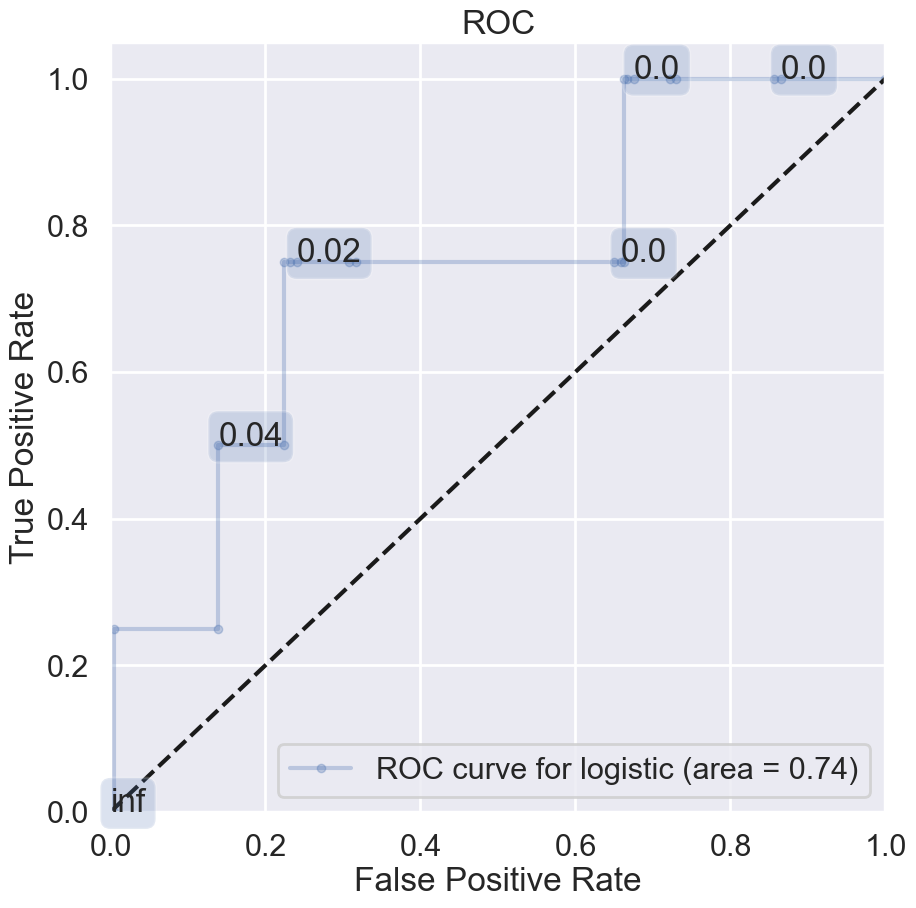

In [70]:
#This is how the above function should be used

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit1, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 5 <a name="q5"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**Your answer goes here**

It tells us that our model is not of the best quality. An AUC fo 0.5 is considered to be the AUC for a random model, while an AUC of 1.0 is the best possible. Our model has an AUC of 0.74, which is slightly closer to random than to the perfect model. It means that with adjusting the threshold, which determines from what "point" in the logistic regression function we classify something as positive, we can make slightly better than random predictions, but we will also increase our false positive rate. It is not incredibly reliable, especially taking into account it is trained on very few/little diverse positive cases. The trade-off for TP and FP rates behaves similarly to linear and thus by increasing TP rate we also increase our FP rate relatively proportionately. For our purposes this means that we cannot reliably predict whether someone is of poor health or not. We most likely in our case need more data or a different way to deal with the data assymetry to improve our model for training.

Within some fields however a model with an AUC of 0.74 could still be usable. In fields where there is a high degree of uncertainty and the impact of a wrong prediction is not disastrous, like with daily weather predictions, a model with an AUC of 0.74 could still provide meaningful insights. If this model is to be used purely to give an indication about someone's health status, for example to flag people for a general health check, then it too can be a helpful tool.

## Let's get back the data with missingness

It's time to build a model to impute the missing data!

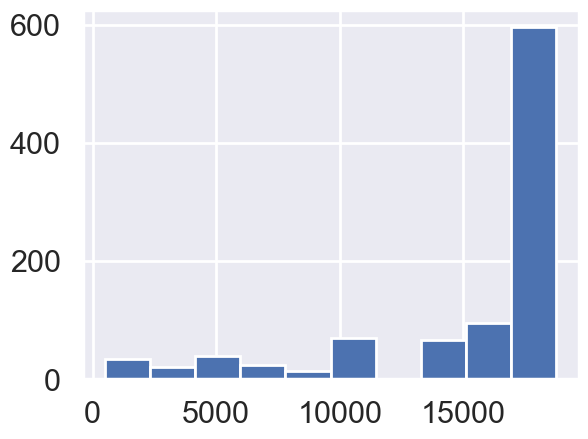

In [71]:
#first build a model to impute using data without missing 
hist = plt.hist(gssdata_full['income'])

---

## 2b: Handling missingness approach \#2: impute the mean 

### Question 6 <a name="q6"></a>

In your first approach, make a copy of the original data frame and impute the missing values by assuming that every missing value shoudl be replaced by the mean. Make sure to do a histogram as well and compare it with the original!

Then fit a model (as before in 2a.) and judge the model accuracy. Use the functions for the ROC curve to establish the result.

In [72]:
#back to the original data set with missingness, make a copy, and then impute the mean, plot it!
###YOUR CODE HERE
###
###
gssnew=gssdata.copy()

gssnew = gssnew.drop(['health','sex','sexornt','partyid','race','notpoorhealth'], axis = 1)
gssnew.head()

,age,educ,married,income,poorhealth,female,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,53,16,1,18750.0,0,0,False,False,True,False,False,False,True,False,False,True
1,26,16,1,18750.0,0,1,False,False,True,False,False,False,True,False,False,True
2,59,13,1,NaN,0,0,False,False,True,False,False,False,True,False,False,True
3,74,17,1,NaN,0,1,False,False,True,False,False,True,False,False,False,True
4,37,10,0,NaN,1,1,False,False,True,False,False,True,False,False,False,True


In [73]:

def impute_data_mean(data:pd.DataFrame, inplace=False)->pd.DataFrame:
    """ Method for imputing missing values around the mean

    Args:
        data (pd.DataFrame): data where we want to impute about the mean
        inplace (bool, optional): whether transformation is inplace or not. Defaults to False.

    Returns:
        pd.DataFrame: copy of the data
    """
    if inplace:
        datacopy = data
    else:
        print('hello')
        datacopy=data.copy()
    for column in datacopy.columns:
        sumNa = datacopy[column].isna().sum()
        print(f'Sum of NaN values in column {column}: {sumNa}')
        if sumNa>0:
            mean = datacopy[column].dropna().mean()
            datacopy[column] = datacopy[column].fillna(mean)
            print(f'Changed missing values of column {column} to mean {mean}')
    return datacopy

def merge_plot_hist(data_org: pd.DataFrame, data_new:pd.DataFrame, column:str):
    """ Method for plotting a merged histogram of two datasets and their respective columns.
        In this case used for original vs clean data.

    Args:
        data_org (pd.DataFrame): Original dataset
        data_new (pd.DataFrame): Cleaned dataset
        column (str): respective column to plot 
    """
    data_org_col = pd.DataFrame(data_org[column])
    data_new_col = pd.DataFrame(data_new[column])
    data_org_col['Dataset'] = 'Original';
    data_new_col['Dataset'] = 'Cleaned';
    combined_data = pd.concat([data_org_col, data_new_col])
    palette = sns.color_palette("bright")
    
    sns.histplot(data = combined_data, x = column, hue = 'Dataset',kde=True, palette=palette);

hello
Sum of NaN values in column age: 0
Sum of NaN values in column educ: 0
Sum of NaN values in column married: 0
Sum of NaN values in column income: 588
Changed missing values of column income to mean 15633.177570093458
Sum of NaN values in column poorhealth: 0
Sum of NaN values in column female: 0
Sum of NaN values in column sexornt_bisexual: 0
Sum of NaN values in column sexornt_dont know: 0
Sum of NaN values in column sexornt_heterosexual or straight: 0
Sum of NaN values in column sexornt_homosexual or gay: 0
Sum of NaN values in column partyid_dem: 0
Sum of NaN values in column partyid_other: 0
Sum of NaN values in column partyid_rep: 0
Sum of NaN values in column race_black: 0
Sum of NaN values in column race_other: 0
Sum of NaN values in column race_white: 0
Shape of new dataset:  (1551, 16)


C:\Users\noahc\AppData\Local\Temp\ipykernel_18712\351433063.py:41: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = combined_data, x = column, hue = 'Dataset',kde=True, palette=palette);


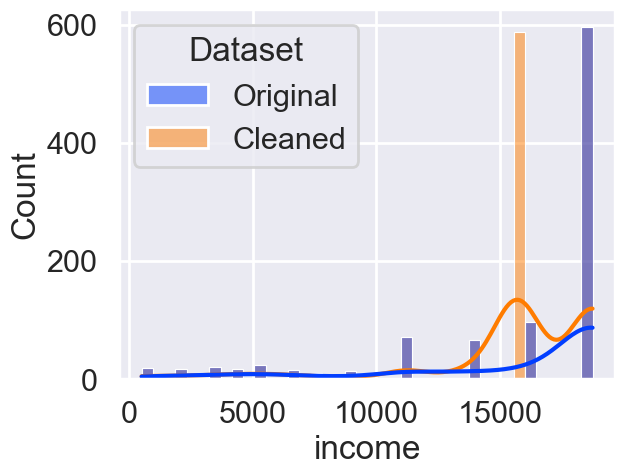

In [74]:
gssnew_clean = impute_data_mean(gssnew)
merge_plot_hist(gssnew.dropna(),gssnew_clean,'income')
print('Shape of new dataset: ',gssnew_clean.shape)

Percentage not in poor health original: 93.61702127659575%
Percentage in poor health original: 6.382978723404255%
Percentage not in poor health cleaned: 93.61702127659575%
Percentage in poor health cleaned: 6.382978723404255%
            count   Dataset
poorhealth                 
0            1452  Original
1              99  Original
0            1452   Cleaned
1              99   Cleaned



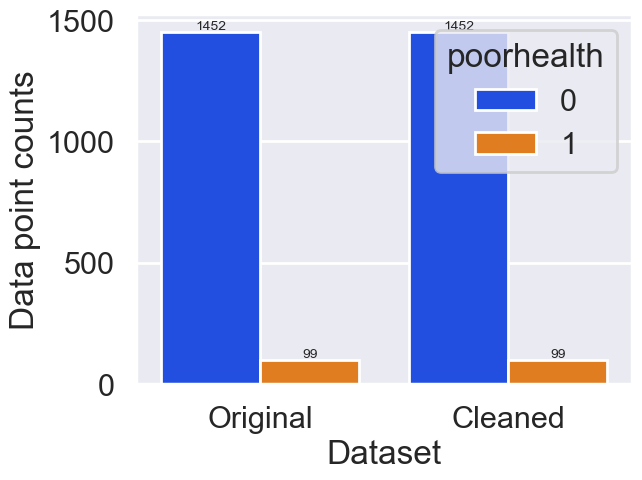

In [75]:
#show histogram of old and cleaned data to reassure that we have same number of positives
combined_data = combine_data_counts(gssnew, gssnew_clean, 'poorhealth')
ax = sns.barplot(combined_data.reset_index(),x='Dataset', y='count',hue='poorhealth',palette=palette)
ax.bar_label(ax.containers[0], fontsize=10);
ax.bar_label(ax.containers[1], fontsize=10);
ax.set_ylabel('Data point counts')

print()

In [76]:
###here, do a proper train/test split and a model training

X = gssnew_clean.drop(['poorhealth'], axis=1) #already dropped the other columns before
y = gssnew_clean['poorhealth']

# Perform the stratified split due to assymmetry
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

print('Original shape of gssnew_clean:', gssnew_clean.shape)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

logit2 = LogisticRegression(C=1000000)
logit2.fit(X_train, y_train);

Original shape of gssnew_clean: (1551, 16)
Shape of X_train: (1163, 15)
Shape of X_test: (388, 15)


In [77]:
#####################
#your code here: create confusion tables for some thresholds to have an idea of how data looks like
####################
i = 0.05
while i < 1.0:
    print(f'Confusion matrices for threshold={i}')
    print('X_test')
    print(confusion_matrix(y_test,t_repredict(logit2, i, X_test)))
    print('X_train')
    print(confusion_matrix(y_train,t_repredict(logit2, i, X_train)))
    print()
    i=round(i+0.05,ndigits=2)

print(f'Training accuracy: {accuracy_score(y_train,logit2.predict(X_train))}')
print(f'Testing accuracy: {accuracy_score(y_test,logit2.predict(X_test))}')


Confusion matrices for threshold=0.05
X_test
[[203 160]
 [  9  16]]
X_train
[[631 458]
 [ 13  61]]

Confusion matrices for threshold=0.1
X_test
[[294  69]
 [ 15  10]]
X_train
[[902 187]
 [ 37  37]]

Confusion matrices for threshold=0.15
X_test
[[328  35]
 [ 18   7]]
X_train
[[1014   75]
 [  52   22]]

Confusion matrices for threshold=0.2
X_test
[[345  18]
 [ 22   3]]
X_train
[[1050   39]
 [  60   14]]

Confusion matrices for threshold=0.25
X_test
[[353  10]
 [ 24   1]]
X_train
[[1063   26]
 [  67    7]]

Confusion matrices for threshold=0.3
X_test
[[358   5]
 [ 24   1]]
X_train
[[1074   15]
 [  71    3]]

Confusion matrices for threshold=0.35
X_test
[[361   2]
 [ 24   1]]
X_train
[[1077   12]
 [  73    1]]

Confusion matrices for threshold=0.4
X_test
[[362   1]
 [ 24   1]]
X_train
[[1084    5]
 [  73    1]]

Confusion matrices for threshold=0.45
X_test
[[363   0]
 [ 24   1]]
X_train
[[1086    3]
 [  73    1]]

Confusion matrices for threshold=0.5
X_test
[[363   0]
 [ 24   1]]
X_train
[

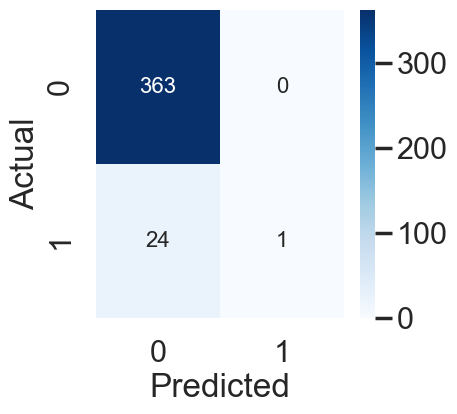

In [78]:
cm = confusion_matrix(y_test, logit2.predict(X_test))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

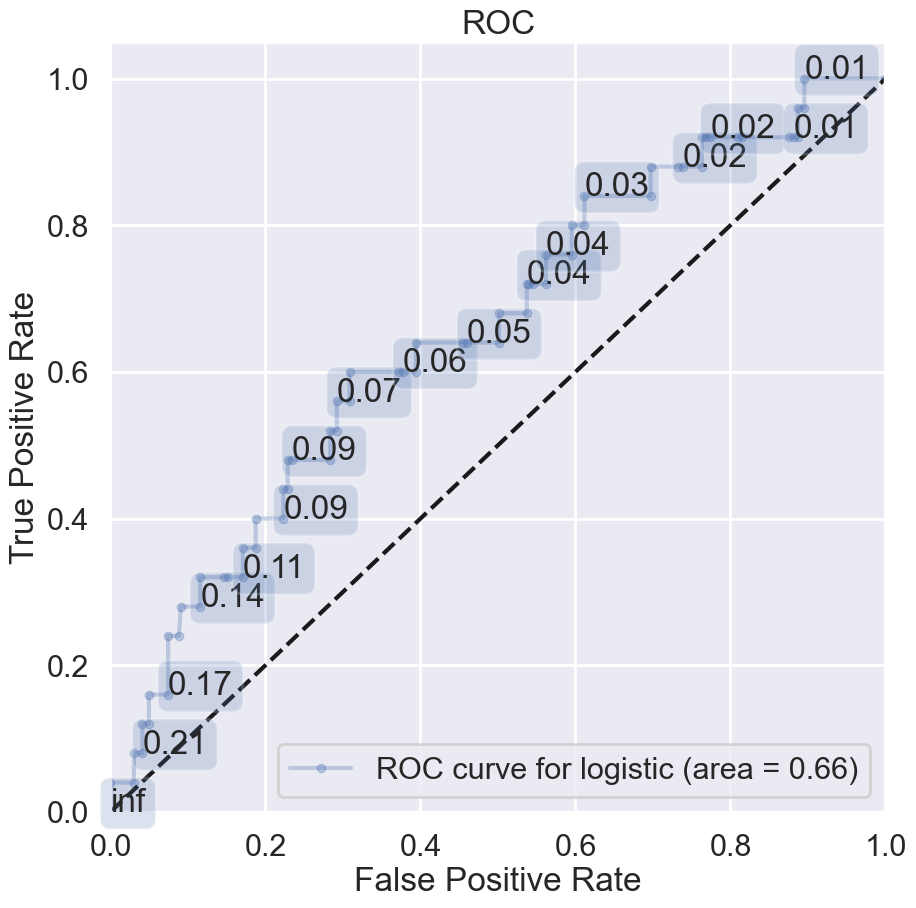

In [79]:
#####################
# your code here: create an ROC curve
#####################

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit2, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 7 <a name="q7"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**your answer goes here**

Again, as in question 5, we observe that our model is not of the best quality. (see question 5 for description and explanation on TP and FP rate, it is also applicable to this curve). We have decreased the AUC from 0.74 to 0.66. It means that again it is not a reliable model to predict whether someone is of poor health or not, even worse so than before. In fact, by having increased the number of positive cases from 16 to 99 and imputing the data for column ``income'' using the mean, we have worsened the performance quite a bit. The data was probably so sparse for positive cases before that we could not appropriately evaluate it and by accident got X_test cases that were similar to the X_train (for the very few that existed). Hence, we got an AUC that is better than this one. This does not mean that the previous model would perform better facing unseen data. However, that does not take away the fact that our logit2 model still doesn't perform well. Perhaps a different methodology could be used to impute the data better, or perhaps the asymmetry is just too large and the dataset too small. 

---

## 2c: Handling missingness approach \#3: impute with a model (linear regression here)

The third and most sophisticated approach would be to fit a linear model (multiple regression) to estimate income based on the other features (`age`, `educ`, `sex`, `partyid`).

### Question 8 <a name="q8"></a>

Train this model below and then use it in order to compute the missing values. The steps should be as follows:

+ figure out which observations have missing values for income,
+ create the values you will use for imputation by:<br>
a) calculating the predicted values for the observations with missingness using the linear model<br>
b) use these values to impute back into the income variable in the missing entries<br>
+ Do a histogram to see how does that look like

In [80]:
import sklearn.linear_model as lm
#use the dataset without NAs here
gssnew_nonan=remove_missing_data(gssnew)
impute_data=gssnew.drop(index=gssnew_nonan.index)
print(gssnew_nonan.shape)
print(impute_data.shape)

We started with 1551 # of data points
We are left with 963 of data points and removed a total of 588 data points
(963, 16)
(588, 16)


In [81]:
#train a model
X_train = gssnew_nonan.drop(['income'],axis=1)
Y_train = gssnew_nonan['income']

X_impute = impute_data.drop(['income'],axis=1)

alphas = np.arange(0.1, 1000, .1)
income_reg_model = lm.RidgeCV(alphas=alphas,cv=5).fit(X_train,Y_train)

income = income_reg_model.predict(X_impute)

KeyboardInterrupt: 

Then fill the missing data with the results you got. You can do that multiple ways, one way to use Python would be the following:

In [ ]:
#you might need to change some of the variables below, but in principle it should work
missing_index = gssdata.income[gssdata.income.isnull()].index
missing_series = pd.Series(data = income, index = missing_index)
#back to the data set with missingness and impute the predictions
gssdata_imp = gssdata.copy()
gssdata_imp['income'] = gssdata_imp['income'].fillna(missing_series)

count     1551.000000
mean     15634.019164
std       4194.786866
min        500.000000
25%      13768.759267
50%      16827.089366
75%      18750.000000
max      20760.759163
Name: income, dtype: float64

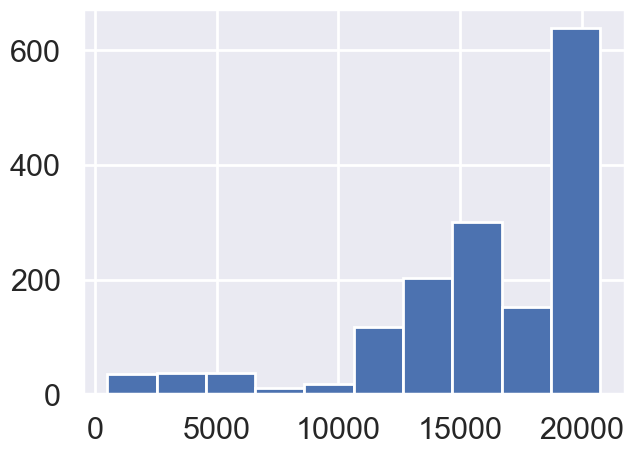

In [ ]:
gssdata_imp['income'].hist(figsize=(7,5))
gssdata_imp['income'].describe()

In [ ]:
#HERE FIT YOUR MODEL AS USUAL FOR PREDICTING THE HEALTH STATUS (POOR OR NOT)
###here, do a proper train/test split and a model training

#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste
X = gssdata_imp.drop(['poorhealth','health','sex','sexornt','partyid','race','notpoorhealth'], axis=1)
y = gssdata_imp['poorhealth']

# Perform the stratified split due to assymmetry
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

print('Original shape of gssdata_imp:', gssdata_imp.shape)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)



Original shape of gssdata_imp: (1551, 22)
Shape of X_train: (1163, 15)
Shape of X_test: (388, 15)


In [ ]:
#here you fit a model
#should be called logit3
logit3 = LogisticRegression(C=1000000)
logit3.fit(X_train, y_train);

Confusion matrices for threshold=0.05
X_test
[[199 164]
 [  6  19]]
X_train
[[638 451]
 [ 14  60]]

Confusion matrices for threshold=0.1
X_test
[[299  64]
 [ 14  11]]
X_train
[[906 183]
 [ 36  38]]

Confusion matrices for threshold=0.15
X_test
[[334  29]
 [ 19   6]]
X_train
[[994  95]
 [ 55  19]]

Confusion matrices for threshold=0.2
X_test
[[351  12]
 [ 19   6]]
X_train
[[1043   46]
 [  60   14]]

Confusion matrices for threshold=0.25
X_test
[[355   8]
 [ 21   4]]
X_train
[[1063   26]
 [  65    9]]

Confusion matrices for threshold=0.3
X_test
[[359   4]
 [ 22   3]]
X_train
[[1074   15]
 [  70    4]]

Confusion matrices for threshold=0.35
X_test
[[361   2]
 [ 23   2]]
X_train
[[1078   11]
 [  72    2]]

Confusion matrices for threshold=0.4
X_test
[[363   0]
 [ 23   2]]
X_train
[[1084    5]
 [  73    1]]

Confusion matrices for threshold=0.45
X_test
[[363   0]
 [ 23   2]]
X_train
[[1085    4]
 [  73    1]]

Confusion matrices for threshold=0.5
X_test
[[363   0]
 [ 23   2]]
X_train
[[108

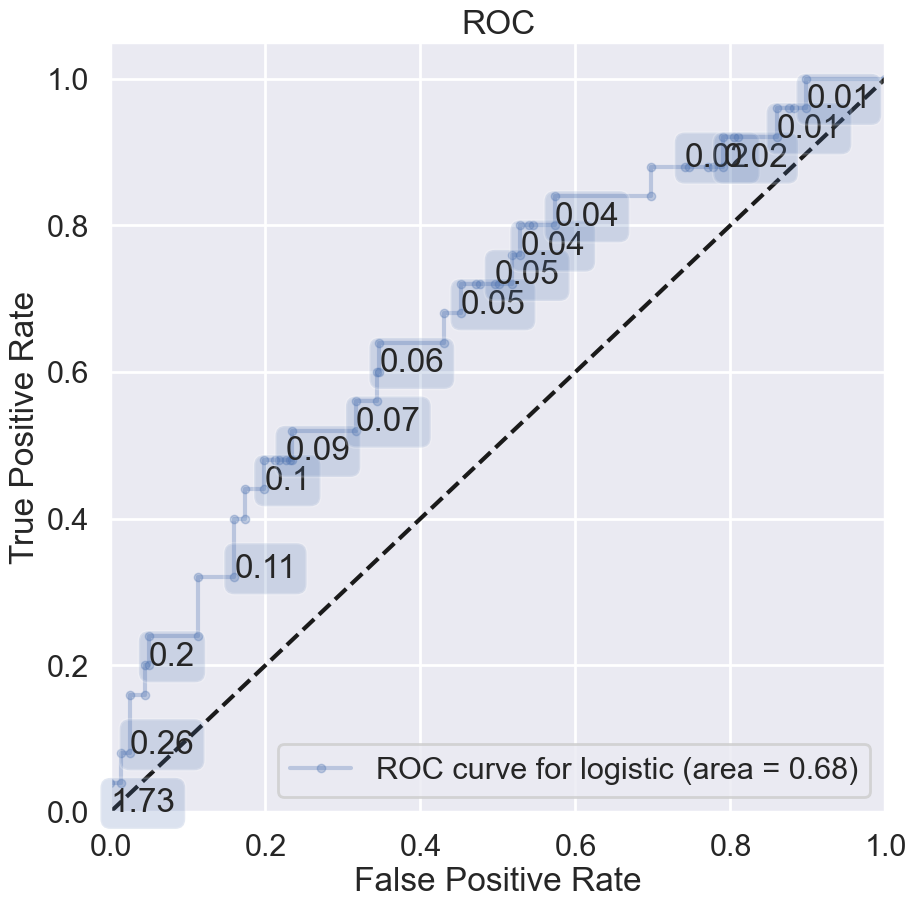

In [ ]:
#MAKE CONFUSION TABLES FOR DIFFERENT THRESHOLDS AND DRAW THE AUROC CURVE
#####################
i = 0.05
while i < 1.0:
    print(f'Confusion matrices for threshold={i}')
    print('X_test')
    print(confusion_matrix(y_test,t_repredict(logit3, i, X_test)))
    print('X_train')
    print(confusion_matrix(y_train,t_repredict(logit3, i, X_train)))
    print()
    i=round(i+0.05,ndigits=2)

print(f'Training accuracy: {accuracy_score(y_train,logit3.predict(X_train))}')
print(f'Testing accuracy: {accuracy_score(y_test,logit3.predict(X_test))}')


# your code here: create an ROC curve
#####################

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit2, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 9 <a name="q9"></a>


Now comment on the performance of difference imputation methods and on the impact it has on the final model performance.


**Your answer goes here**

For our logit3 model we got slightly better performance and managed to increase our AUC by 0.02 compared to the logit2 model. However, our model still performs relatively poorly and the FP-rate increases almost proportionately to an increase in TP-rate when increasing the threshold. It seems that by using different methods for imputing we can indeed get slightly better performance using different imputation methods. Using linear regression trained on the non-empty instances to impute the missing values of other instances intuitively seems like a better and more robust way of dealing with missing data. Especially for small datasets where simply emitting instances with empty values can have negative effects on the performance of our model on unseen and data with high variance. However, especially in this case, if we want to improve our model more we need to use different techniques to get more informatioon on the positive cases. There is simply not enough data for positive cases to properly train our model. Random forest might be able to deal with this in a better way and also bootstrapping our dataset (sampling with replacement).

In conclusion, using imputation techniques will increase the performance of our model depending on the type of imputation technique. However, for severe data assymmetry, if we want to make a model that properly predicts minority cases we need to use different methods and/or models to deal with this assymmetry.

## Part 3: Improving the model.

### Question 10 <a name="q10"></a>


Apply regularization (with cross-validation) to make sure not to overfit to the data and try also different models, like a Decision Tree or a Random Forest. Report on your results for which model handles inbalances in the best way.

**Your checklist**

Here is a checklist for this clinic (classification) made by a TA some years ago.

- [ ] What are the correlations between variables?<br>
- [x] What is the distribution of your variables? How does the histogram look like? <br>
- [x] Are there missing values? How can you handle them? <br>
- [x] How does dropping missing values affect the distribution? <br>
- [x] How does imputing from mean affect the distribution? <br>
- [x] How does imputing from model affect the distribution? <br>
- [ ] How does imputation influence correlation between variables? <br>
- [ ] What is the difference between precision and accuracy? <br>
- [x] What is the difference between Type I and Type II error? <br>
- [x] How is a ROC curve build? What do the tresholds represent? <br>
- [x] How is the ROC curve affected by dropping NaN? <br>
- [x] How is the ROC curve affected by imputing mean? <br>
- [x] How is the ROC curve affected by imputing from a model? <br>
- [ ] What is the difference between overfitting and class imbalance? <br> 
- [ ] How does the the amount of folds in cross validation affect model performance? <br>

In [ ]:
## your code goes here
